# CVA method for Epidemic Inference
This notebook is aimed at explaining how to use the code for the CVA method applied to epidemics inference. We'll do so by generating a graph and simulationg an SI epidemics at continuous time using a simple markovian dynamical model. Then, we are going to simulate some observations on the population (clinical tests) and from those observations we'll run CVA in order to resconstruct the original epidemics. 
In the second part of this notebook we have also implemented some other methods existent in literature in order to perform a comparison of performances.

In [36]:
using SparseArrays, LinearAlgebra, IndexedGraphs
using ProgressMeter
#using Pkg
#Pkg.activ§ate("../")
using Causality
using Plots

# Simulation Part
Here we simulate the graph generation and the epidemic spreading

## Graph Generation 


In [37]:
# We first have to set the total time of the epidemics and the number of individuals.
T, N = 20.0, 40

#Then we can set the model for graph generation. You can comment/uncomment for changing graph or you can code it 
G = Causality.makeProximity(N,2.1/N)
#G = Causality.makeBarabasi(N,k=2)
#G = Causality.makeGNP(N,3/N)

{40, 166} directed sparse Int64 graph
⠄⠁⠀⠀⠐⠂⠀⠕⠀⠀⠅⠀⠀⠅⠁⡀⡀⡀⠰⠈
⠀⠀⠄⠁⠀⠀⠀⠐⠅⢀⠨⠪⢁⠐⢀⠐⠐⢀⠂⠀
⠰⠀⠀⠀⠠⠂⢁⠖⠀⠀⠀⢀⠀⠀⠀⠈⠀⠄⠰⡀
⢄⠄⢀⠀⢡⠔⠀⠀⠀⠀⠄⠐⠀⠄⠀⠈⢀⠀⠠⠀
⠀⠀⠁⢁⠀⠀⠀⠀⠀⠀⠈⠈⢀⠀⢄⠀⠐⢀⠀⠂
⠁⠁⡢⡂⠀⢀⢀⠁⡂⠀⢀⠐⠂⠡⠁⠀⠠⠀⠄⠉
⠄⠄⢁⠐⠀⠀⠀⠄⠀⠐⠌⡀⠀⠀⠐⠀⢀⠂⡁⠠
⠁⠠⢀⠐⡀⠀⡀⠀⠀⠑⠁⠀⠐⠀⠀⠀⠄⠔⠀⠉
⠀⠨⠐⢀⠀⠄⠀⠐⠐⢀⠀⠂⠠⠐⢀⠅⠄⠁⠀⠂
⡐⠂⠈⠀⠐⠢⠀⠂⠠⠀⡄⠁⠁⡈⡄⠀⠠⠀⠀⠀

## Epidemic Generation

In [38]:
#This cell contains the definition of getpar
#This function returns the matrix of transition rates.

getpar(pseed,autoinf::GaussianRate,inf_in::GaussianRate) = 
    [fill(pseed, 1, N);
     fill(autoinf.a, 1, N); fill(autoinf.b, 1, N); fill(autoinf.c, 1, N);
     fill(inf_in.a,   1, N); fill(inf_in.b, 1, N); fill(inf_in.c, 1, N);
    ]

getpargen(pseed, autoinf::GaussianRate, inf_out::GaussianRate) = 
    [pseed autoinf.a autoinf.b autoinf.c inf_out.a inf_out.b inf_out.c]


getpargen (generic function with 1 method)

In [39]:
#In this cell we set all the generating parameters to simulate the SI epidemics

ε = 1e-10 # a small number that will be used later for e.g. autoinfection
λ = 0.08 # infection rate 
pseed = 1/N #probability of being the zero patient
autoinf = GaussianRate(ε, T/2, 1/ε) # autoinfection rate at nonzero times

# the following is the gaussian representing the incoming infection. We fix it to 1
# with average T/2 and std dev ≈ ∞
inf_in = GaussianRate(1.0, T/2, 1/ε) 

# the following is the outgoing infection rate. The product of outgoing and incoming is the total infection. 
#Since the incoming is 1 and the ougoing is λ we have the desired infection
#The reason why we build two quantities is for the inference part. The inf_in will play the role of the set of inference
#parameters, while the inf_out is the generating model. See later.
inf_out = GaussianRate(λ, T/2, 1/ε)
#if you want to use a non markovian model, it is sufficient to impose a non constant rate, as: inf_out = GaussianRate(λ, 3.0, 1.0)
#where for example we state that the peak of infectivity is after 3 unit times form infection with a fluctuation of 1 unit time.


#We finally build the model parameters. We give the pseed, the autoinfection gaussian, the infection gaussian
θp = getpar(pseed, autoinf, inf_in); #this is a 7 x N  matrix which plays an important role in inference. Not for simulation
θpgen = getpargen(pseed, autoinf, inf_out); # this is a vector of 7 values which is the generative vactor of parameters

In [40]:
#Initialize min/max boundaries
T = Float64(T)
pseed_min = ε
pseed_max = 1-ε
rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  2T,   1/ε)

inf_min = GaussianRate(ε  ,  -T,   ε)
inf_max = GaussianRate(1/ε  ,  2T, 1. )

θmin = getpar(pseed_min , rate_min, rate_min);
θmax = getpar(pseed_max , rate_max, rate_max);

rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  T,   T)

θgenmin = getpargen(pseed_min, rate_min, rate_min);
θgenmax = getpargen(pseed_max, rate_max, rate_max);

In [41]:
#this is to specify that the generative rates and inferential rates are gaussians
const Igen = GenerativeSI{GaussianRate,GaussianRate} 
const Igauss = GaussianInferentialSI

GaussianInferentialSI

Total fraction of infected at final time: 0.75


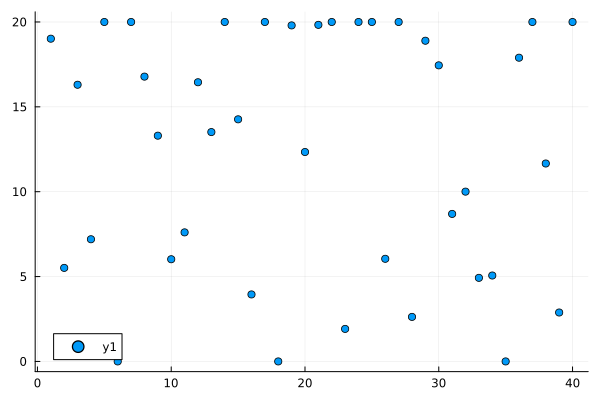

In [43]:
# V is a vector containing the time interval of each contact in the graph
# In this example we are studying a static graph so we set all the time intevals to be  [0,T]
V = fill(MaskedRate(UnitRate(),Causality.intervalUnion(0,T)), ne(G));
#We initialize the generative SI model
Mp = StochasticModel(Igen, T, θp, G, θpgen, V);
#We sample from the generative model a trajectory x
sample! = Sampler(Mp);
xtrue = zeros(N)
sample!(xtrue)

#We plot the infection time of each individual. If this time is T it means no infection happened
println("Total fraction of infected at final time: ", sum(xtrue .< T)/N)
scatter(xtrue)
#scatter!(xtrue .+ 1)
#scatter!(xtrue .- 1)

## Simulation of clinical tests

In [44]:
# herer we fix the 
nobs = 35 #number of observations
p = 1e-5 # false rate (noise of observations)
O = [(ti = T; (i,xtrue[i] < ti,ti,p)) for i=1:nobs]; #array of all the observations

# Inference with CVA
Here we use the observations in order to reconstruct the epidemics with the CVA method.

In [45]:
#Softened model.
# Now we rebuild an auxiliary model which is the one we will use for inference
ε = 2e-3 #This time the "small number" is higher in order to avoid numerical issues in gradient descent
autoinf = GaussianRate(ε, T/2, T); #we initialize the autoinfeciton as before. 
θp2gen = getpargen(pseed, autoinf, inf_out);
inf_in = GaussianRate(1., T/2, 3*T ); # the incoming infection is initialized to 1 but it will move in inference

#notice that also the std deviations are smaller now.

θp2 = getpar(pseed, autoinf, inf_in); #the softened generative model
Mp2 = StochasticModel(Igen, T, θp2, G, θp2gen, V);

In [46]:
θ = getpar(pseed, autoinf, inf_in); #this is the matrix of inference parameters
autoinf = GaussianRate(1., T/2, T);
M = StochasticModel(Igauss, T, θ, G, θp2gen, V);

## The descent

In [47]:
# This is the crucial point. We do a descent to make M the most similar to Mp2.
# Recall that Mp2 is a "soft" version of the TRUE stochastic model Mp with which we simulated the epidemics.
# Recall that M is the effective stochastic model (the core of CVA) that approximates the posterior
ProgressMeter.ijulia_behavior(:clear)
F = descend!(Mp2, O; M=M, numsamples=500, numiters=50, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
         hyperdescender=SignDescender(0.));
F = descend!(Mp2, O; M=M, numsamples=500, numiters=50, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.03),
         hyperdescender=SignDescender(0.));

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
  F:  18.273598276209878


In [48]:
statscaunew = prior(M, numsamples=3000); #here we collect a set of independent parameters from the effective model M

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


# Comparison with other methods


## SoftMarg

In [49]:
Osoft = [(o[1],o[2],o[3],p) for o in O];

In [50]:
stats, weights = softpostnoise(Mp, Osoft; numsamples=3 * 10^4);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


## Sib

In [51]:
using PyCall
@pyimport sib
function sibyl(N, T_cont, Λ, O, γ, λ ; dt=1/5, maxit = 400, tol = 1e-14)
    
    T = Int(round(T_cont / dt))
    contacts = [(i-1,j-1,t, λ * dt) for t in 1:T for (j,i,v) in zip(findnz(Λ.A)...)];
    obs = [[(i,-1,t) for t=1:T for i=0:N-1];
           [(i-1,s,Int(round(t/dt))) for (i,s,t,p) in O]]
    sort!(obs, lt=((i1,s1,t1),(i2,s2,t2))->(t1<t2))
    prob_sus = 0.5
    prob_seed=γ
    pseed = prob_seed / (2 - prob_seed)
    psus = prob_sus * (1 - pseed)
    params = sib.Params(prob_r=sib.Exponential(mu=0), pseed=pseed, psus=psus,pautoinf=0)
    f = sib.FactorGraph(contacts=contacts, observations=obs, params=params)
    sib.iterate(f, maxit=maxit,tol=tol)
    sib.iterate(f, maxit=maxit, damping=0.5, tol=tol)
    sib.iterate(f, maxit=maxit, damping=0.9, tol=tol)
    p_sib=[collect(n.bt) for n in f.nodes]
    m_sib = zeros(N, T)
    for i=1:N
        m_sib[i,1] = p_sib[i][1] 
        for t=2:T
            m_sib[i,t] = m_sib[i,t-1] + p_sib[i][t]
        end
    end 
    return m_sib
end


sibyl (generic function with 1 method)

In [52]:
a=time()
dt = 1/4
p_sib = sibyl(N, T, G, O, pseed, λ; dt=dt, maxit = 20, tol = 1e-7);
b=time()
println(b-a)

sib.iterate(damp=0.0): 19/20 6.641e-03/1e-07      
sib.iterate(damp=0.5): 19/20 7.211e-04/1e-07      
2.0058131217956543.9): 19/20 3.380e-04/1e-07      



## Heuristic MF

In [53]:
using IntervalUnionArithmetic
T = Float64(T)
struct HeuristicSI <: SI end
θp2gen = getpargen(pseed, autoinf, inf_out);
maskauto = fill(intervalUnion(0., T),N)
maskinf = fill(intervalUnion(0., T),N)
θfrench = getpar(pseed, autoinf, inf_in);
Causality.individual(M::StochasticModel{HeuristicSI}, i::Int, θi = @view(M.θ[:,i]), θg = M.θgen ) = 
@views IndividualSI(θi[1], 
    MaskedRate(GaussianRate(θi[2:4]...),maskauto[i]), 
    MaskedRate(UnitRate(),maskinf[i]), 
    GaussianRate(θg[5:7]...),)
inf_start_time = T * ones(N)
for o in O
    if o[2] == 1
        inf_start_time[o[1]] = min(inf_start_time[o[1]], o[3] - 5)
        maskauto[o[1]] = maskauto[o[1]] ∩ intervalUnion(o[3]-5, T)       
        θfrench[2,o[1]] = 10^10
        θfrench[3,o[1]] = o[3] - 5
        θfrench[4,o[1]] = 100 * T
    elseif o[2] == 0
        maskinf[o[1]] = maskinf[o[1]] ∩ intervalUnion(o[3], T)
        maskauto[o[1]] = maskauto[o[1]] ∩ intervalUnion(o[3], T)
        θfrench[1,o[1]] = 1e-10
    end
end
for i=1:N
    if inf_start_time[i] != T 
        maskauto[i] = maskauto[i] ∩ intervalUnion(inf_start_time[i], T)
    end
end
Mfrench = StochasticModel(HeuristicSI, T, θfrench, G, θp2gen);
statsfre = prior(Mfrench,numsamples=10000); 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [54]:
function MF_heu(N, T_cont, Λ, O, γ, λ ; dt=1/5, maxit = 400)
    T = Int(round(T_cont / dt))
    p_MF = zeros(N,T) #prob to be S
    p_MF[:,1] .= 1 - γ 
    obs_I = [o[1] for o in O if o[2] == 1]
    obs_S = [o[1] for o in O if o[2] == 0]
    for st = 1:maxit
        for t = 2:T
            for i = 1:N
                p_MF[i,t] = p_MF[i,t-1]
                for j in collect(Causality.outedges(Λ,1))
                    p_MF[i,t] *= 1 - λ*(1 - p_MF[j.dst,t-1])
                end
                if i in obs_I                    
                    o = O[i]
                    p_MF[i, Int(round((o[3]-5)/dt)) : end] .= 0
                end
                if i in obs_S
                    o = O[i]
                    p_MF[i, 1 : Int(round(o[3]/dt))] .= 1
                end
            end
        end
    end
    return 1 .- p_MF
end

MF_heu (generic function with 1 method)

In [55]:
p_MF = MF_heu(N, T, G, [], 1/N, λ ; dt=dt, maxit = 100);

## Metropolis Monte Carlo

In [56]:
K =  Causality.RectifiedGaussMove(4.0)
#stats_mh = Causality.metropolis_sampling_parallel(Mp, O, K; numsamples = 10^3,numsteps=10^3,nfirst = 10^3)
stats_mh = Causality.metropolis_sampling_sequential(Mp, O, K; numsamples = 5 * 10^2,numsteps=10^2,nfirst = 10^2);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
  acc_ratio:  0.55



# Comparisons among methods: Marginals and ROC curve

In [57]:
function marginal(i, t, stats)
    numsamp = size(stats,1)
    sum(stats[:,i] .< t)/numsamp
end

function reweighted_marginal(i, t, stats, weights)
    numsamp = size(stats,1)
    @assert numsamp == size(weights,1)
    weights ./= maximum(weights)
    sum(weights .* (stats[:,i] .< t))/sum(weights)
end

function tpr(xtrue, rank) 
    cumsum(xtrue[rank]) ./( cumsum(xtrue[rank])[end])
end

function fpr(xtrue, rank) 
    N = size(rank,1)
    return (range(1,N,length=N) .- cumsum(xtrue[rank])) ./ (range(1,N,length=N) .- cumsum(xtrue[rank]) )[end]
end

function ROC(xtrue, p)
    N = size(xtrue,1)
    rank = sortperm(p, rev=true)
    
    return fpr(xtrue, rank) , tpr(xtrue, rank)
end

function AUROC(ROC)
    N = size(ROC[1],1) 
    AU = 0
    for t = 1:N-1
        AU += ROC[2][t] * (ROC[1][t+1] - ROC[1][t])
    end
    return AU
end

AUROC (generic function with 1 method)

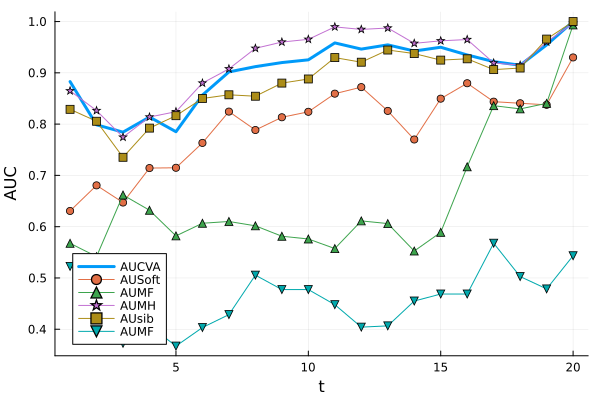

In [60]:
#AUROC curves

T = Int(T)
AU_curvenew=zeros(T)
AU_sib=zeros(T)
AU_MF=zeros(T)
AU_french = zeros(T)
AU_soft = zeros(T)
AU_MH = zeros(T)
for t = 1:T
    cau_risknew=zeros(N)
    sib_risk = zeros(N)
    MF_risk = zeros(N)
    french_risk = zeros(N)
    MH_risk = zeros(N)
    soft_risk = zeros(N)
    for i=1:N
       cau_risknew[i]= marginal(i,t,statscaunew)
       french_risk[i] = marginal(i,t,statsfre)
       MH_risk[i] = marginal(i,t,stats_mh)
       sib_risk[i] = p_sib[i,Int(round(t/dt))]
        MF_risk[i] = p_MF[i,Int(round(t/dt))]
       soft_risk[i] = reweighted_marginal(i, t*T/bins, stats, weights)
    end
    xt = xtrue .< t
    AU_soft[t] = AUROC(ROC(xt, soft_risk))
    AU_curvenew[t] = AUROC(ROC(xt, cau_risknew))
    AU_french[t] = AUROC(ROC(xt, french_risk))
    AU_MH[t] = AUROC(ROC(xt, MH_risk))
    AU_sib[t] = AUROC(ROC(xt, sib_risk))
    AU_MF[t] = AUROC(ROC(xt, MF_risk))
end

plot(LinRange(1,T,T),AU_curvenew, width=3, label="AUCVA")
plot!(LinRange(1,T,T),AU_soft, marker=:c, label="AUSoft",legend=:bottomleft)
plot!(LinRange(1,T,T),AU_french, marker=:ut, label="AUMF")
plot!(LinRange(1,T,T),AU_MH,marker=:star, label="AUMH")
plot!(LinRange(1,T,T), AU_sib, marker=:square,label="AUsib")
plot!(LinRange(1,T,T), AU_MF,marker=:dt, label="AUMF")
xlabel!("t")
ylabel!("AUC")
#ylims!(0.5,1.01)